# Instructions

## file structure.

```
Data
│
└───Dataset
│   └───sample
│   │   └───Coordinates
|   |   |     |   coordinates.csv  
│   │   └───Principal_Components
|   |   |     └───Principal_Component
|   |   |         └───CSV
|   |   |             |   pcs_30_from_bayesSpace_top_2000_HVGs.csv
│   │   └───reading_h5
│   |       |   adata.h5
│   |
│   └───manual_annotations.csv
    └───manual_scribble.csv
```

## you will get everything if you run this. 
###Except the manual annotaion, you will get this if you have a .tsv manual annotation url
###and you have to provide the manual scribble
###and also mclust scribble

#Installations

In [ ]:
!pip --quiet install scanpy
!pip --quiet install stlearn

#Imports and constants

In [ ]:
import scanpy as sc
import stlearn as st
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re

In [ ]:
npcs = 30
nHVGs = 2000
dataset = "others"
sample = "bcdc_ffpe"
man_ann_url = "https://raw.githubusercontent.com/JinmiaoChenLab/SEDR_analyses/master/data/BRCA1/metadata.tsv"

#Prepear Anndata This will vary from dataset to dataset

## For some case you can down load the whole data using a sample id
### sc.datasets.visium_sge(ID)
## For some case you have to prepear the directory like
```
data
│
└───Dataset Name
│   └───spatial
│   │   |
|   |   |    scalefactors_json.json  
|   |   |    tissue_hires_image.png
|   |   |    tissue_lowres_image.png 
|   |   |    tissue_positions_list.csv
│   │
│   |
│   └───filtered_feature_bc_matrix.h5


```
### and call sc.read_visium(path='Dataset Name')

#Downloading code

In [ ]:
# adata = sc.datasets.visium_sge(
#     sample_id="V1_Breast_Cancer_Block_A_Section_1"
# )

In [ ]:
adata = sc.read_visium("/content/drive/MyDrive/Thesis-Documents/Data/Breast Cancer Ductal Carcinoma")

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


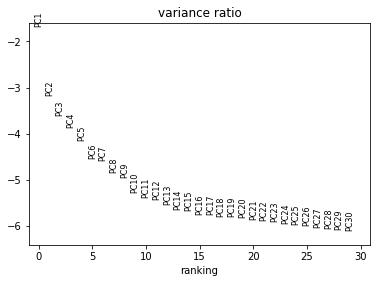

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pp.pca(adata,n_comps=npcs)
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
st.convert_scanpy(adata)

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

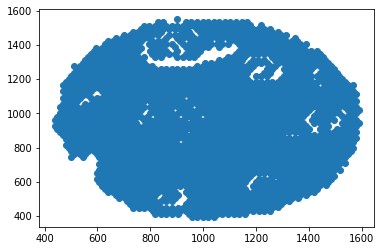

In [ ]:
plt.scatter(adata.obs['imagecol'],adata.obs['imagerow'])

In [ ]:
!mkdir -p Data/{dataset}/{sample}/Coordinates

df = pd.DataFrame([adata.obs['imagecol'],adata.obs['imagerow']]).T
df.to_csv(f'Data/{dataset}/{sample}/Coordinates/coordinates.csv')

In [ ]:
!mkdir -p Data/{dataset}/{sample}/Principal_Components/CSV

df = pd.DataFrame(adata.obsm['X_pca'],index=adata.obs_names)
df.to_csv(f'Data/{dataset}/{sample}/Principal_Components/CSV/pcs_30_from_bayesSpace_top_2000_HVGs.csv')

In [ ]:
response = requests.get(man_ann_url)
open("manual_ann.tsv", "wb").write(response.content)

with open("/content/manual_ann.tsv", 'r') as myfile: 
  with open("/content/manual_ann.csv", 'w') as csv_file:
    for line in myfile:
      fileContent = re.sub("\t", ",", line)
      csv_file.write(fileContent)

df = pd.read_csv('/content/manual_ann.csv')

# type_anot = 'fine_annot_type'
type_anot='annot_type'

regions = df[type_anot].unique()
dict = {}
cnt = 1
for region in regions:
  dict[region] = cnt
  cnt+=1

df = df.replace({type_anot:dict})
df_man_ann = pd.DataFrame(data = {'label':df[type_anot].tolist()}, index=df['ID'].tolist())

df_man_ann.to_csv(f'Data/{dataset}/{sample}/manual_annotations.csv')

! rm /content/manual_ann.*

In [ ]:
!mkdir -p Data/{dataset}/{sample}/reading_h5
adata.write(f'Data/{dataset}/{sample}/reading_h5/adata.h5', compression="gzip")

In [ ]:
! zip -r Data.zip /content/Data

updating: content/Data/ (stored 0%)
updating: content/Data/others/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/reading_h5/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/reading_h5/adata.h5 (deflated 6%)
  adding: content/Data/others/bcdc_ffpe/Principal_Components/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/Principal_Components/CSV/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/Principal_Components/CSV/pcs_30_from_bayesSpace_top_2000_HVGs.csv (deflated 56%)
  adding: content/Data/others/bcdc_ffpe/Coordinates/ (stored 0%)
  adding: content/Data/others/bcdc_ffpe/Coordinates/coordinates.csv (deflated 65%)
  adding: content/Data/others/bcdc_ffpe/manual_annotations.csv (deflated 72%)


In [ ]:
! rm -rf ./Data/